# Part 2 - Data Analysis

For this project, the requirement is to use the flights dataset to predict if a particular flight in the future will be cancelled. This first notebook is used to explore the data.

**NOTE -** This notebook will only execute if you have run the project with `STORAGE_MODE == external` and if you have _EnvironmentUser_ and _DWUser_ roles assigned to your account.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import cml.data_v1 as cmldata

from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [2]:
# This code block can be ommitted after the CML Aug release ()
import glob

paths = glob.glob("/opt/spark/optional-lib/*.jar")
workingJars = [
    "hive-warehouse-connector-assembly.jar",
    "iceberg-spark-runtime.jar",
]
includeList = [
    path for path in paths if any(jar in path for jar in workingJars)
]
jarsList = ",".join(includeList)
SparkContext.setSystemProperty("spark.jars",jarsList)

SparkContext.setSystemProperty("spark.sql.catalog.spark_catalog", "org.apache.iceberg.spark.SparkSessionCatalog")
SparkContext.setSystemProperty("spark.sql.catalog.spark_catalog.type", "hive")
SparkContext.setSystemProperty("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions")


Setting spark.hadoop.yarn.resourcemanager.principal to peterableda


## Create the Spark session
Connect to spark using the standard Spark Session connector. I've put the connection parameters into each file directly they change depending on the type of job that is running. You should adjust the following for your specific Spark environment.

+ `spark.executor.memory`
+ `spark.executor.cores`

In [3]:
SparkContext.setSystemProperty('spark.executor.cores', '4')
SparkContext.setSystemProperty('spark.executor.memory', '8g')

SPARK_CONNECTION_NAME = os.getenv("SPARK_CONNECTION_NAME")
conn = cmldata.get_connection(SPARK_CONNECTION_NAME)
spark = conn.get_spark_session()

## Load the Spark UI
This creates a link the Spark UI. If you are running locally, just run `spark` as a command in a cell and it will provide you with the Spark UI link.

In [4]:
from IPython.core.display import HTML

HTML(
    '<a href="http://spark-{}.{}" target="_blank">Spark UI</a>'.format(
        os.getenv("CDSW_ENGINE_ID"), os.getenv("CDSW_DOMAIN")
    )
)

## Fetch the data
We are using data from [Kaggle](https://www.kaggle.com/yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018) that's loaded into a CDW Virtual Warehouse. We are going to access the data stored directly in the DataLake and process it with Spark running in the CML Workspace.

> _HANDY TIP_
> 
> Use `.persist()` on a data frame that you are work a lot with to prevent Spark from fetching the data everytime you run query. It will store that dataframe in memory and all operations on that dataframe will run on the in-memory version.

In [5]:
# specify the table the data is available in (you may need to edit this)
dw_database = os.environ["DW_DATABASE"]
dw_table = os.environ["DW_TABLE"]

flight_df = spark.sql(f"select * from {dw_database}.{dw_table}")

# Uncomment this if you are running in local mode and just want to see things work
# flight_df = flight_df.limit(10000)

flight_df.persist()

Hive Session ID = 323fc2c8-0b7d-47c0-ab95-0c145711c82c


DataFrame[month: int, dayofmonth: int, dayofweek: int, deptime: int, crsdeptime: int, arrtime: int, crsarrtime: int, uniquecarrier: string, flightnum: int, tailnum: string, actualelapsedtime: int, crselapsedtime: int, airtime: int, arrdelay: int, depdelay: int, origin: string, dest: string, distance: int, taxiin: int, taxiout: int, cancelled: int, cancellationcode: string, diverted: string, carrierdelay: int, weatherdelay: int, nasdelay: int, securitydelay: int, lateaircraftdelay: int, year: int]

## Cancelled Flights by Carrier
The first bit of data exploration is to check the flight cancellations by carrier. This is best done by showing which carrier has the highet percentage of cancelled flights rather than the total number of cancelled flights. 

Concepts introduced in this section:
+ `filter()`,`groupby` etc.
+ `withColumn` and `withColumnRenamed`
+ `toPandas()`

In [6]:
flight_df.printSchema()

root
 |-- month: integer (nullable = true)
 |-- dayofmonth: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- deptime: integer (nullable = true)
 |-- crsdeptime: integer (nullable = true)
 |-- arrtime: integer (nullable = true)
 |-- crsarrtime: integer (nullable = true)
 |-- uniquecarrier: string (nullable = true)
 |-- flightnum: integer (nullable = true)
 |-- tailnum: string (nullable = true)
 |-- actualelapsedtime: integer (nullable = true)
 |-- crselapsedtime: integer (nullable = true)
 |-- airtime: integer (nullable = true)
 |-- arrdelay: integer (nullable = true)
 |-- depdelay: integer (nullable = true)
 |-- origin: string (nullable = true)
 |-- dest: string (nullable = true)
 |-- distance: integer (nullable = true)
 |-- taxiin: integer (nullable = true)
 |-- taxiout: integer (nullable = true)
 |-- cancelled: integer (nullable = true)
 |-- cancellationcode: string (nullable = true)
 |-- diverted: string (nullable = true)
 |-- carrierdelay: integer (nullable 

In [7]:
cancel_by_carrier = flight_df\
  .filter("cancelled == 1")\
  .groupby("uniquecarrier")\
  .count()\
  .sort("count",ascending=False)\
  .withColumnRenamed('count', 'count_delays')

  
flight_by_carrier = flight_df\
  .groupby("uniquecarrier")\
  .count()\
  .sort("count",ascending=False)\
  .withColumnRenamed('count', 'count_total')

  
cancel_by_carrier_percent = flight_by_carrier\
  .join(
    cancel_by_carrier, 
    flight_by_carrier.uniquecarrier == cancel_by_carrier.uniquecarrier
  )
  
cancel_by_carrier_percent = cancel_by_carrier_percent\
  .withColumn(
    "delay_percent",(
      cancel_by_carrier_percent.count_delays/cancel_by_carrier_percent.count_total
    )*100
  )\
  .sort("delay_percent",ascending=False)\
  .toPandas()

cancel_by_carrier_percent.head(10)

,uniquecarrier,count_total,uniquecarrier,count_delays,delay_percent
0,OH,2974,OH,121,4.068594
1,MQ,7959,MQ,294,3.693931
2,YV,1767,YV,64,3.621958
3,DH,1484,DH,51,3.436658
4,9E,1093,9E,34,3.110704
5,UA,17651,UA,479,2.713727
6,NW,13741,NW,362,2.634452
7,US,16528,US,385,2.329380
8,AA,19665,AA,450,2.288330
9,EV,3361,EV,76,2.261232


# Cancelled flights by Year
This is not necessarily useful as a predictive metric, but it is still interesting.

In [8]:
flight_by_year = flight_df\
  .groupby("year")\
  .count()\
  .sort("count",ascending=False)\
  .withColumnRenamed('count', 'count_total')
  
cancel_by_year = flight_df\
  .filter("cancelled == 1")\
  .withColumnRenamed("year","year_cancel")\
  .groupby("year_cancel")\
  .count()\
  .sort("count",ascending=False)\
  .withColumnRenamed('count', 'cancel_total')

cancel_by_year_percent = flight_by_year\
  .join(
    cancel_by_year, 
    flight_by_year.year == cancel_by_year.year_cancel
  )  
  
cancel_by_year_percent = cancel_by_year_percent\
  .withColumn(
    "delay_percent",(
      cancel_by_year_percent.cancel_total/cancel_by_year_percent.count_total
    )*100
  )\
  .sort("year",ascending=False)
  
cancel_by_year_percent_pd = cancel_by_year_percent.toPandas()

Plot this using a Tufte-like layout :)

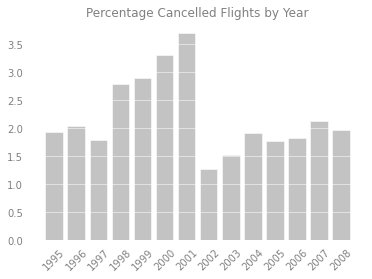

In [9]:
sns.set_style("white",{'axes.axisbelow': False})
plt.bar( 
  cancel_by_year_percent_pd.year, 
  cancel_by_year_percent_pd.delay_percent,
  align='center', 
  alpha=0.5,
  color='#888888',
)
plt.grid(color='#FFFFFF', linestyle='-', linewidth=0.5, axis='y')
plt.title(
  'Percentage Cancelled Flights by Year',
  color='grey'
)
plt.xticks(
  cancel_by_year_percent_pd.year,
  color='grey',
  rotation=45    
)
plt.yticks(color='grey')
sns.despine(left=True,bottom=True)

## Cancelled flights per Week of Year
This is a more intersting statistic and likely to have more predictive power. Week of Year will be a seasonal and generally the flight patterns will have busier vs less busy times of the year. This will also show the effect that seasonal weather conditions can have on flight cancellations.

In [10]:
flight_df = flight_df.withColumn(
    "fl_date",
    to_date(
        concat_ws("/", col("year"), col("month"), col("dayofmonth")),
        "yyyy/M/d",
    ),
)

flight_by_week = flight_df\
  .withColumn("week",weekofyear("fl_date"))\
  .groupby("week")\
  .count()\
  .sort("count",ascending=False)\
  .withColumnRenamed('count', 'count_total')
  
cancel_by_week = flight_df\
  .filter("cancelled == 1")\
  .withColumn("week",weekofyear("fl_date"))\
  .withColumnRenamed("week","week_cancel")\
  .groupby("week_cancel")\
  .count()\
  .sort("count",ascending=False)\
  .withColumnRenamed('count', 'cancel_total')

cancel_by_week_percent = flight_by_week\
  .join(
    cancel_by_week, 
    flight_by_week.week == cancel_by_week.week_cancel
  )  
  
cancel_by_week_percent = cancel_by_week_percent\
  .withColumn(
    "delay_percent",(
      cancel_by_week_percent.cancel_total/cancel_by_week_percent.count_total
    )*100
  )\
  .sort("week",ascending=False)
  
cancel_by_week_percent_pd = cancel_by_week_percent.toPandas()

In [11]:
cancel_by_week_percent_pd

,week,count_total,week_cancel,cancel_total,delay_percent
0,53,487,53,23,4.722793
1,52,3226,52,109,3.378797
2,51,3265,51,79,2.419602
3,50,3233,50,94,2.907516
4,49,3305,49,77,2.329803
5,48,3201,48,59,1.843174
6,47,3156,47,29,0.918885
7,46,3221,46,53,1.645452
8,45,3314,45,44,1.327701
9,44,3245,44,40,1.232666


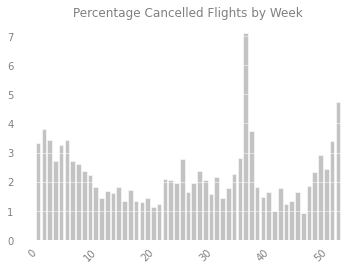

In [12]:
def plotter():
  sns.set_style("white",{'axes.axisbelow': False})
  plt.bar( 
    cancel_by_week_percent_pd.week, 
    cancel_by_week_percent_pd.delay_percent,
    align='center', 
    alpha=0.5,
    color='#888888',
  )
  plt.grid(color='#FFFFFF', linestyle='-', linewidth=0.5, axis='y')
  plt.title(
    'Percentage Cancelled Flights by Week',
    color='grey'
  )
  plt.xticks(
    color='grey',
    rotation=45
  )
  plt.yticks(color='grey')
  sns.despine(left=True,bottom=True)
plotter()

## Calculating Cancelled Routes
To work out if route is likely to cancalled, the easiest way is to create a string that combines the origin and destination. However that works only in a single direction, so calculate for both directions, the code below uses `hash` to create an interger that is the sum of the origin and a hash of the destination. This creates a commutative process for any route.


> HANDY TIP
> In pyspark you can aggregate inside a `select` function (i.e. use `sum` etc) if its not after a groupby

In [13]:
all_routes = flight_df\
  .withColumn("combo_hash", hash("origin")+hash("dest"))\
  .withColumn("combo", concat(col("origin"),col("dest")))\
  .groupby("combo_hash")\
  .agg(count("combo_hash").alias("count_all"),first("combo").alias("route_alias_all"))\
  .sort("count_all",ascending=False)

cancelled_routes_all = flight_df\
  .filter("cancelled == 1")\
  .withColumn("combo_hash", hash("origin")+hash("dest"))\
  .withColumn("combo", concat(col("origin"),col("dest")))\
  .groupby("combo_hash")\
  .agg(count("combo_hash").alias("count"),first("combo").alias("route_alias"))\
  .sort("count",ascending=False)  

cancelled_routes_percentage = cancelled_routes_all\
  .join(
    all_routes,
    cancelled_routes_all.combo_hash == all_routes.combo_hash
  )\
  .withColumn(
    "route", 
    concat(
      substring(col("route_alias"),0,3),
      lit("<>"),
      substring(col("route_alias"),4,6)
    )
  )\
  .withColumn(
    "cancelled_percent", 
    col("count")/col("count_all")*100
  )\
  .select("route","count","count_all","cancelled_percent")\
  .sort("cancelled_percent",ascending=False)

cancelled_routes_percentage.toPandas().head(10)

,route,count,count_all,cancelled_percent
0,PNS<>BTR,2,2,100.000000
1,MEM<>SAN,1,1,100.000000
2,GTR<>DFW,1,1,100.000000
3,RDU<>ORF,1,1,100.000000
4,MDW<>GSO,1,1,100.000000
5,SPI<>IAD,2,3,66.666667
6,ASE<>PHX,2,3,66.666667
7,ASE<>ORD,2,4,50.000000
8,AZO<>ATL,2,4,50.000000
9,PIT<>BGR,1,2,50.000000


### Side Note
Interestingly most popular routes have similar numbers of cancelled flights in either direction.

In [14]:
cancelled_by_route_non_combo = flight_df\
  .filter("cancelled == 1")\
  .withColumn("combo", concat(col("origin"),col("dest")))\
  .groupby("combo")\
  .count()\
  .sort("count",ascending=False)

cancelled_by_route_non_combo.toPandas().head(10)

,combo,count
0,LGAORD,28
1,SFOLAX,24
2,EWRORD,23
3,LGABOS,21
4,MSPORD,20
5,ORDLGA,20
6,LAXSFO,19
7,BOSORD,18
8,ORDEWR,18
9,BOSLGA,16


## Find Unused Columns
Given that our aim is to calculate a prediction for the CANCELLED variable, many of the other columns are no longer relevant. You don't have an actual wheels down time for a cancelled flight. The code below lists the colums that have lots of NA values on cancelled flights.

In [15]:
unused_columns = flight_df\
  .filter("cancelled == 1")\
  .agg(*(sum(isnull(c).cast('int')).alias(c) for c in flight_df.columns))

unused_columns_df = unused_columns.toPandas()
unused_columns_df_t = unused_columns_df.transpose()
unused_columns_df_t.rename( columns={0 :'count'}, inplace=True )
unused_columns_df_t.query('count>0').index.values

array(['deptime', 'arrtime', 'actualelapsedtime', 'crselapsedtime',
       'airtime', 'arrdelay', 'depdelay', 'taxiin', 'taxiout',
       'carrierdelay', 'weatherdelay', 'nasdelay', 'securitydelay',
       'lateaircraftdelay'], dtype=object)

In [16]:
spark.stop()

***If this documentation includes code, including but not limited to, code examples, Cloudera makes this available to you under the terms of the Apache License, Version 2.0, including any required notices.  A copy of the Apache License Version 2.0 can be found [here](https://opensource.org/licenses/Apache-2.0).***